In [1]:
import numpy as np
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt 
from models.gru import GRU
from losses.correlation_loss import CorrelationLoss
from losses.hybrid_loss import HybridLoss
from models.attention_gru import AttentionGRU

In [2]:
train_path = "../datasets/btc-2024-11-24.csv"
test_path = "../datasets/btc-2024-11-25.csv"

train_df = pd.read_csv(train_path, sep="|")
test_df = pd.read_csv(test_path, sep="|")

In [3]:
for dataset in [train_df, test_df]:
    dataset["datetime"] = pd.to_datetime(dataset["time"], unit="us")
    dataset.set_index("datetime", inplace=True)


train_df = train_df.resample("1s").last().ffill() # there are some seconds where no updates occur
test_df = test_df.resample("1s").last().ffill()

In [4]:
train_df.head()

,pair,time,bid_0_price,bid_0_size,bid_1_price,bid_1_size,bid_2_price,bid_2_size,bid_3_price,bid_3_size,...,ask_20_price,ask_20_size,ask_21_price,ask_21_size,ask_22_price,ask_22_size,ask_23_price,ask_23_size,ask_24_price,ask_24_size
datetime,,,,,,,,,,,,,,,,,,,,,
2024-11-24 00:00:00,BTCUSDT,1.732406e+15,97725.5,553419.5065,97725.4,7915.7574,97725.3,40165.0983,97725.2,488.626,...,97734.1,195.4682,97734.2,488.671,97734.3,4300.3092,97734.7,1563.7552,97735.1,195.4702
2024-11-24 00:00:01,BTCUSDT,1.732406e+15,97725.5,553419.5065,97725.4,7915.7574,97725.3,40165.0983,97725.2,488.626,...,97734.1,195.4682,97734.2,488.671,97734.3,4300.3092,97734.7,1563.7552,97735.1,195.4702
2024-11-24 00:00:02,BTCUSDT,1.732406e+15,97725.5,553419.5065,97725.4,7915.7574,97725.3,40165.0983,97725.2,488.626,...,97734.1,195.4682,97734.2,488.671,97734.3,4300.3092,97734.7,1563.7552,97735.1,195.4702
2024-11-24 00:00:03,BTCUSDT,1.732406e+15,97725.5,553419.5065,97725.4,7915.7574,97725.3,40165.0983,97725.2,488.626,...,97734.1,195.4682,97734.2,488.671,97734.3,4300.3092,97734.7,1563.7552,97735.1,195.4702
2024-11-24 00:00:04,BTCUSDT,1.732406e+15,97725.5,553419.5065,97725.4,7915.7574,97725.3,40165.0983,97725.2,488.626,...,97734.1,195.4682,97734.2,488.671,97734.3,4300.3092,97734.7,1563.7552,97735.1,195.4702


In [5]:
for dataset in [train_df, test_df]:
    dataset["midprice"] = (dataset["bid_0_price"] + dataset["ask_0_price"]) / 2
    dataset["bid_volume"] = dataset[[f"bid_{i}_size" for i in range(25)]].sum(axis=1)
    dataset["ask_volume"] = dataset[[f"ask_{i}_size" for i in range(25)]].sum(axis=1)
    dataset["total_volume"] = dataset["bid_volume"] + dataset["ask_volume"]
    dataset["log_return"] = np.log(dataset["midprice"]) - np.log(dataset["midprice"].shift(1))
    dataset["target_log_return"] = dataset["log_return"].shift(-1)
    dataset.dropna(inplace=True)

In [6]:
train_df[["midprice", "bid_volume", "ask_volume", "total_volume", "log_return", "target_log_return"]].describe()

,midprice,bid_volume,ask_volume,total_volume,log_return,target_log_return
count,86398.000000,8.639800e+04,8.639800e+04,8.639800e+04,8.639800e+04,8.639800e+04
mean,97499.441476,1.124449e+06,9.418992e+05,2.066348e+06,2.778752e-08,2.778752e-08
std,796.559822,2.173591e+06,8.791433e+05,2.339793e+06,5.868779e-05,5.868779e-05
min,95829.850000,8.719118e+03,9.585293e+03,2.522825e+05,-2.164931e-03,-2.164931e-03
25%,96788.450000,4.489733e+05,4.585076e+05,1.294734e+06,0.000000e+00,0.000000e+00
50%,97738.950000,7.463102e+05,7.598066e+05,1.605151e+06,0.000000e+00,0.000000e+00
75%,98225.450000,1.161106e+06,1.156429e+06,2.060940e+06,0.000000e+00,0.000000e+00
max,98617.950000,1.001985e+08,1.941460e+07,1.002864e+08,2.406803e-03,2.406803e-03


In [7]:
feature_cols = ["midprice", "bid_volume", "ask_volume", "total_volume", "log_return"] \
    + [f"bid_{i}_size" for i in range(25)] \
    + [f"bid_{i}_price" for i in range(25)] \
    + [f"ask_{i}_size" for i in range(25)] \
    + [f"ask_{i}_price" for i in range(25)]

target_cols = ["target_log_return"]

In [8]:
class BtcDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [9]:
# Create sequences for AttentionGRU
def create_sequences(features, targets, seq_length=5):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(targets[i + seq_length])
    return torch.stack(X), torch.stack(y)

In [ ]:
PARAMS = {
    "sequence_length": 13,
    "hidden_dim": 16,
    "epochs": 5,
    "batch_size": 32,
    "lr": 0.001,
}

In [ ]:
train_features_df = train_df[feature_cols]
train_targets_df = train_df[target_cols]

test_features_df = test_df[feature_cols]
test_targets_df = test_df[target_cols]



train_features = torch.tensor(train_features_df.values, dtype=torch.float32)
train_targets = torch.tensor(train_targets_df.values, dtype=torch.float32)
test_features = torch.tensor(test_features_df.values, dtype=torch.float32)
test_targets = torch.tensor(test_targets_df.values, dtype=torch.float32)

train_features, train_targets = create_sequences(train_features, train_targets, PARAMS["sequence_length"])
test_features, test_targets = create_sequences(test_features, test_targets, PARAMS["sequence_length"])

In [45]:
train_dataset = BtcDataset(train_features, train_targets)
test_dataset = BtcDataset(test_features, test_targets)

train_loader = DataLoader(train_dataset, batch_size=PARAMS["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=PARAMS["batch_size"], shuffle=False)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AttentionGRU(len(feature_cols), PARAMS["hidden_dim"], len(feature_cols), len(target_cols), device).to(device)
criterion = CorrelationLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=PARAMS["lr"])

for epoch in range(PARAMS["epochs"]):
    model.train()
    epoch_loss = 0

    for batch_features, batch_targets in train_loader:
        optimizer.zero_grad()
        outputs, _ = model(batch_features, batch_features)
        loss = criterion(outputs[:, -1, :], batch_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"epoch: {epoch+1}, loss: {epoch_loss}")

epoch: 1, loss: 2526.91594350338
epoch: 2, loss: 2609.5401108264923
epoch: 3, loss: 2646.5311880111694
epoch: 4, loss: 2632.0953892469406
epoch: 5, loss: 2633.0414341688156


In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_features, batch_targets in test_loader:
            # Move data to device
            batch_features = batch_features.to(device)
            batch_targets = batch_targets.to(device)
            
            # Get model predictions
            outputs, _ = model(batch_features, batch_features)
            
            # Take the last time step predictions
            predictions = outputs[:, -1, :]
            
            # Collect predictions and targets
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(batch_targets.cpu().numpy())
    
    # Concatenate all predictions and targets
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    return all_predictions, all_targets

def plot_results(y_true, y_pred, feature_name, feature_index):
    # y_true = y_true.cpu().numpy()
    # y_pred = y_pred.cpu().numpy()
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:, feature_index], label="Actual", linestyle='', marker='o')
    plt.plot(y_pred[:, feature_index], label="Predicted", linestyle='', marker='x')
    plt.title(f"Actual vs Predicted {feature_name}", fontsize=16)
    plt.xlabel("Timestep", fontsize=14)
    plt.ylabel(feature_name, fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

In [47]:
# Evaluate the model
predictions, targets = evaluate_model(model, test_loader, device)

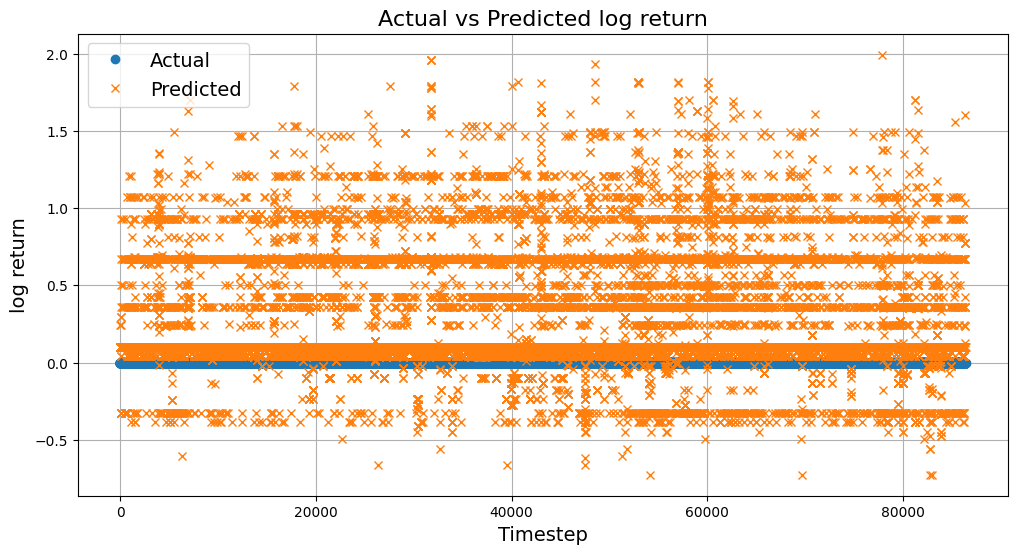

In [48]:
plot_results(targets, predictions, "log return", 0)